In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import os
import random


from empirical_data import *
from optimized_random_response import *
from randomized_response import *
from repetitive_optimizer import *
from synthetic_dataset import *
from exponential_mechanism import *
from simpleinfotheory import *
from normalize_error_matrix import *

import matplotlib as mpl
import matplotlib.lines as mlines


## Generate Synthetic Datasets

In [12]:
from alphabet import *

NUM_ATTRIBUTES = 2
NUM_STATES = [2, 4]
DATASET_SIZE = 10000

priority_dict = {'1': 1, '0': 1}

TOTAL_STATES = 1
alphabet_dict = {}
for i in range(NUM_ATTRIBUTES):
    TOTAL_STATES *= NUM_STATES[i]
    alphabet_dict[str(i)] = np.arange(NUM_STATES[i])

ALL_ALPHABET = create_alphabet(attributes_with_alphabet=alphabet_dict)
STRING_ALL_ALPHABET = convert_alphabet_to_string(ALL_ALPHABET)
ATTRIBUTE_LIST = list(alphabet_dict.keys())
random_dist = np.array([random.randint(1, 5000) for i in range(TOTAL_STATES)])
random_dist = random_dist/np.sum(random_dist)
# random_dist = [0.6, 0.2, 0.01, 0.09, 0.05, 0.05] # [0.2, 0.11, 0.01, 0.01, 0.20, 0.11, 0.11, 0.01, 0.24] #  # [0.3, 0.01, 0.01, 0.01, 0.30, 0.01, 0.01, 0.01, 0.34]
# random_dist = [0.35, 0.15, 0.15, 0.35] # [0.25, 0.25, 0.25, 0.25] # [0.5, 0.025, 0.025, 0.45]
# random_dist_2 = [0.45, 0.05, 0.05, 0.45]
print("Alphabet ", ALL_ALPHABET)
print("ATTRIBUTE_LIST ", ATTRIBUTE_LIST)

synthetic_dataset_constructor = Gen_Synthetic_Dataset(no_of_states = TOTAL_STATES, no_of_samples = DATASET_SIZE, alphabet=STRING_ALL_ALPHABET)
correlated_synthetic_dataset = synthetic_dataset_constructor.gen_custom(distribution=random_dist)

uniform_synthetic_dataset = synthetic_dataset_constructor.gen_uniform()



Alphabet  [[0 0]
 [0 1]
 [0 2]
 [0 3]
 [1 0]
 [1 1]
 [1 2]
 [1 3]]
ATTRIBUTE_LIST  ['0', '1']


## Claculate Error Matrix

{'[0 0]': 0, '[0 1]': 1, '[0 2]': 2, '[0 3]': 3, '[1 0]': 4, '[1 1]': 5, '[1 2]': 6, '[1 3]': 7}


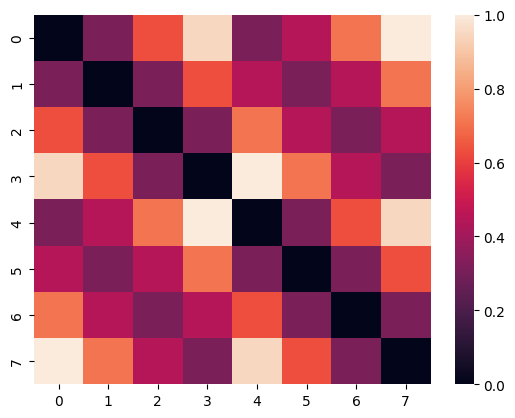

In [13]:
alphabet_dict = {}
for i in range(len(ALL_ALPHABET)):
    alphabet_dict[str(ALL_ALPHABET[i])] = i
print(alphabet_dict)
normalize_error_matrix = Normalize_error_matrix(attribute_list=ATTRIBUTE_LIST, alphabet=ALL_ALPHABET, priority_dict=priority_dict, alphabet_dict=alphabet_dict)
err_matrix = normalize_error_matrix.normalized_error_matrix
sns.heatmap(err_matrix)
plt.show()

## Calculate Mutual Information

### Pair-wise information leakage of A: I(A;A')

In [14]:
def mutual_info_pair(a, b):
    return mutualinformationempirical(xn=a, yn=b)[0]

### Total information leakage of A: I(A;A',B')

In [15]:
# I(A;A',B') = I(A;A') + I(A;B'|A')

def conditional_mutual_info(a, b, c):
    return conditionalmutualinformationempirical(a, b, c)

def total_info_leakage(A, A_prime, B_prime):
    return mutual_info_pair(A, A_prime) + conditional_mutual_info(A, B_prime, A_prime)

In [16]:
def mutual_information(a, b):
    processed_a = []
    # print(a)
    # print(b)
    for i in a:
        actual_split = i.split(" ")
        actual = []
        # print(actual_split)
        for j in actual_split:
            # print(i)
            if j != "" :
                actual.append(int(j))
        processed_a.append(np.array(actual))
    processed_a = np.array(processed_a)
    processed_b = []
    
    for i in b:
        actual_split = i.split(" ")
        actual = []
        # print(actual_split)
        for j in actual_split:
            # print(i)
            if j != "" :
                actual.append(int(j))
        processed_b.append(np.array(actual))
    processed_b = np.array(processed_b)

    mi = []
    # print("processed_a", processed_a)
    # print("processed_b", processed_b)
    # for i in range(np.shape(processed_b)[1]):
    #     mi.append(mutual_info_pair(processed_a[:,i], processed_b[:,i]))
    # mi.append(mutual_info_pair(processed_a[:,0], processed_a[:,1]))
    # mi.append(mutual_info_pair(processed_b[:,1], processed_b[:,0]))
    # mi.append(mutual_info_pair(processed_a[:,0], processed_b[:,0]))
    # mi.append(mutual_info_pair(processed_a[:,1], processed_b[:,1]))
    mi.append(total_info_leakage(processed_a[:,0], processed_b[:,0], processed_b[:,1]))
    # mi.append(total_info_leakage(processed_a[:,1], processed_b[:,1], processed_b[:,0]))
    # mi.append(total_info_leakage(processed_a[:,0], processed_b[:,1], processed_b[:,0]))
    return mi
    

## Benchmark Optimal Mechanism

In [17]:
EPS_ARRAY = np.arange(10)*0.5

### Correlated Distribution - k-RR and Optimal

0.0
0.5
1.0
1.5
2.0
2.5


/Users/sandarujayawardana/Documents/Python_code/.venv/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


3.0
3.5
4.0
4.5


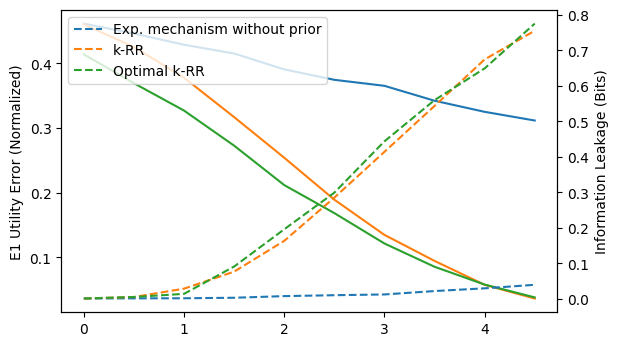

In [18]:
exponential_mechanism_without_prior = Exponential_mechanism(prior_dist=random_dist, STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix, only_err_matrix=True)
random_response_mechanism = Randomized_Response(STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix)
optimal_random_response_mechanism = Optimized_Randomized_Response(prior_dist = random_dist, STATE_COUNT = TOTAL_STATES, INPUT_ALPHABET = STRING_ALL_ALPHABET, normalized_objective_err_matrix = err_matrix, 
                 TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "SCS", is_kl_div = True, ALPHA=0.01)

mechanisms_dict = {"Exp. mechanism without prior": exponential_mechanism_without_prior, "k-RR": random_response_mechanism, "Optimal k-RR": optimal_random_response_mechanism}

colour_err_ = {"k-RR": "red", "Exp. mechanism without prior": "green", "Optimal k-RR": "blue"}
colour_mi_ = {"k-RR": "lightsalmon", "Exp. mechanism without prior": "brown", "Optimal k-RR": "purple"}

error_dict = {}
mi_dict = {}
total_mi_dict = {}

for key in list(mechanisms_dict.keys()):
    error_dict[key] = []
    mi_dict[key] = []
    total_mi_dict[key] = []

for eps in EPS_ARRAY:
    for mechanism in list(mechanisms_dict.keys()):
        __tot_error = 0
        __perturbed_value_list = []
        for entry in correlated_synthetic_dataset:
            __perturbed_value_list.append(mechanisms_dict[mechanism].gen_random_output(actual_value=entry, eps=eps)[0])
            __error = normalize_error_matrix.get_value_error(actual=entry, perturbed=__perturbed_value_list[-1])
            __tot_error += __error
        error_dict[mechanism].append(__tot_error/len(uniform_synthetic_dataset))
        # mi_dict[mechanism].append(mutual_info_pair(correlated_synthetic_dataset, __perturbed_value_list))
        mi_dict[mechanism].append(mutual_information(correlated_synthetic_dataset, __perturbed_value_list))
fig, axs = plt.subplots()
# axs.set_xscale('log')
ax2 = axs.twinx()
legend_ = [] 
for mechanism in list(mechanisms_dict.keys()):
    legend_.append(mechanism)
    axs.plot(EPS_ARRAY, error_dict[mechanism])
    # for mi_ in range(len(mi_dict[mechanism][0])):
    
    

for mechanism in list(mechanisms_dict.keys()):
    for mi_ in range(len(mi_dict[mechanism][0])):
        # print(colour_mi_[mechanism][mi_])
        legend_.append(mechanism)
        ax2.plot(EPS_ARRAY, np.array(mi_dict[mechanism])[:,mi_], linestyle='--') #, color=colour_mi_[mechanism][mi_])

# handles = [mlines.Line2D([], [], color='red', label='E1 Utility Error (k-RR)'),
#            mlines.Line2D([], [], color='blue', label='E1 Utility Error (Optimal)'),
#            mlines.Line2D([], [], color='lightsalmon', label='Info. Leakage, Attribute-A (k-RR)'),
#            mlines.Line2D([], [], color='green', label='Info. Leakage, Attribute-A (Optimal)'),
#            mlines.Line2D([], [], color='brown', label='Info. Leakage, Attribute-B (k-RR)'),
#            mlines.Line2D([], [], color='purple', label='Info. Leakage, Attribute-B (Optimal)'),]
# fig.legend(handles=handles, loc='lower center', ncol=2)
fig.subplots_adjust(bottom=0.25)
plt.xlabel("Privacy Budget (Epsilon)")
plt.legend(legend_)
ax2.set_ylabel("Information Leakage (Bits)")
axs.set_ylabel("E1 Utility Error (Normalized)")
plt.show()

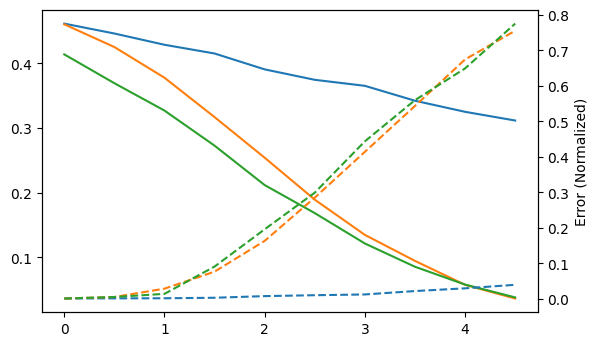

In [19]:
fig, axs = plt.subplots()
# axs.set_xscale('log')
ax2 = axs.twinx()
for mechanism in list(mechanisms_dict.keys()):
    axs.plot(EPS_ARRAY, error_dict[mechanism])
    # for mi_ in range(len(mi_dict[mechanism][0])):
    ax2.plot(EPS_ARRAY, np.array(mi_dict[mechanism]), linestyle='--')

# handles = [mlines.Line2D([], [], color='red', label='E1 Utility Error (k-RR)'),
#            mlines.Line2D([], [], color='blue', label='E1 Utility Error (Optimal)'),
#            mlines.Line2D([], [], color='lightsalmon', label='Info. Leakage, Attribute-A (k-RR)'),
#            mlines.Line2D([], [], color='green', label='Info. Leakage, Attribute-A (Optimal)'),
#            mlines.Line2D([], [], color='brown', label='Info. Leakage, Attribute-B (k-RR)'),
#            mlines.Line2D([], [], color='purple', label='Info. Leakage, Attribute-B (Optimal)'),]
# fig.legend(handles=handles, loc='lower center', ncol=2)
fig.subplots_adjust(bottom=0.25)
plt.xlabel("Privacy Budget (Epsilon)")
plt.ylabel("Error (Normalized)")
plt.show()

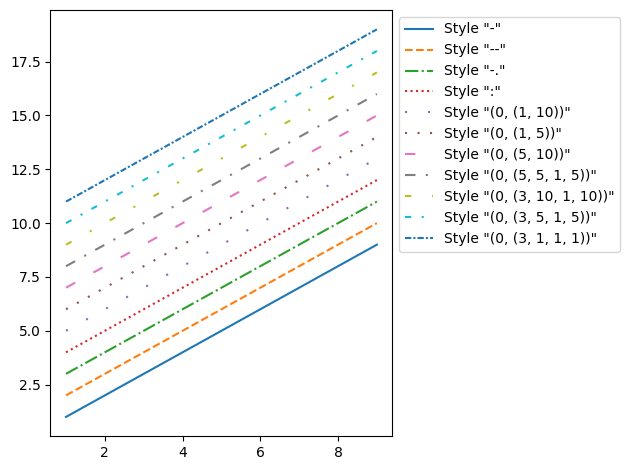

In [20]:
import matplotlib.pyplot as plt

# Create a figure and an axes
fig, ax = plt.subplots()

# Example data
x = range(1, 10)

# Different dashed line styles
styles = ['-', '--', '-.', ':',
          (0, (1, 10)), (0, (1, 5)), (0, (5, 10)), (0, (5, 5, 1, 5)),
          (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1))]

# Creating lines with different dash styles
for i, style in enumerate(styles):
    y = [xi + i for xi in x]
    ax.plot(x, y, linestyle=style, label=f'Style "{style}"')

# Setting the legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
